# Cross-Country Solar Comparison

Comparing solar potential across Benin, Sierra Leone, and Togo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

In [6]:
# Load cleaned datasets
benin_df = pd.read_csv('..\\data\\benin_clean.csv')
sierra_leone_df = pd.read_csv('..\\data\\sierraleone_bumbuna_qc_clean.csv')  # Replace with actual path
togo_df = pd.read_csv('..\\data\\togo_dapaong_qc_clean.csv')  # Replace with actual path

# Add country identifier
benin_df['Country'] = 'Benin'
sierra_leone_df['Country'] = 'Sierra Leone'
togo_df['Country'] = 'Togo'

print(f'Benin data shape: {benin_df.shape}')
print(f'Sierra Leone data shape: {sierra_leone_df.shape}')
print(f'Togo data shape: {togo_df.shape}')

Benin data shape: (525600, 27)
Sierra Leone data shape: (525601, 28)
Togo data shape: (525601, 29)


In [7]:
# Combine all datasets
all_data = pd.concat([benin_df, sierra_leone_df, togo_df], ignore_index=True)
print(f'Combined data shape: {all_data.shape}')
all_data.head()

Combined data shape: (1576802, 29)


,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,...,DNI_zscore,DHI_zscore,ModA_zscore,ModB_zscore,WS_zscore,WSgust_zscore,cleaning_flag,Country,Timestamp,GHIrsi
0,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,...,0.639591,0.733873,0.723749,0.723088,1.322831,1.187312,0,Benin,NaN,NaN
1,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,...,0.639591,0.733873,0.723749,0.723088,1.322831,1.384442,0,Benin,NaN,NaN
2,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,...,0.639591,0.733873,0.723749,0.723088,1.135736,0.842334,0,Benin,NaN,NaN
3,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,...,0.639209,0.733243,0.723749,0.723088,1.198101,1.039464,0,Benin,NaN,NaN
4,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,...,0.639209,0.733243,0.723749,0.723088,1.260466,1.039464,0,Benin,NaN,NaN


## Metric Comparison - Boxplots

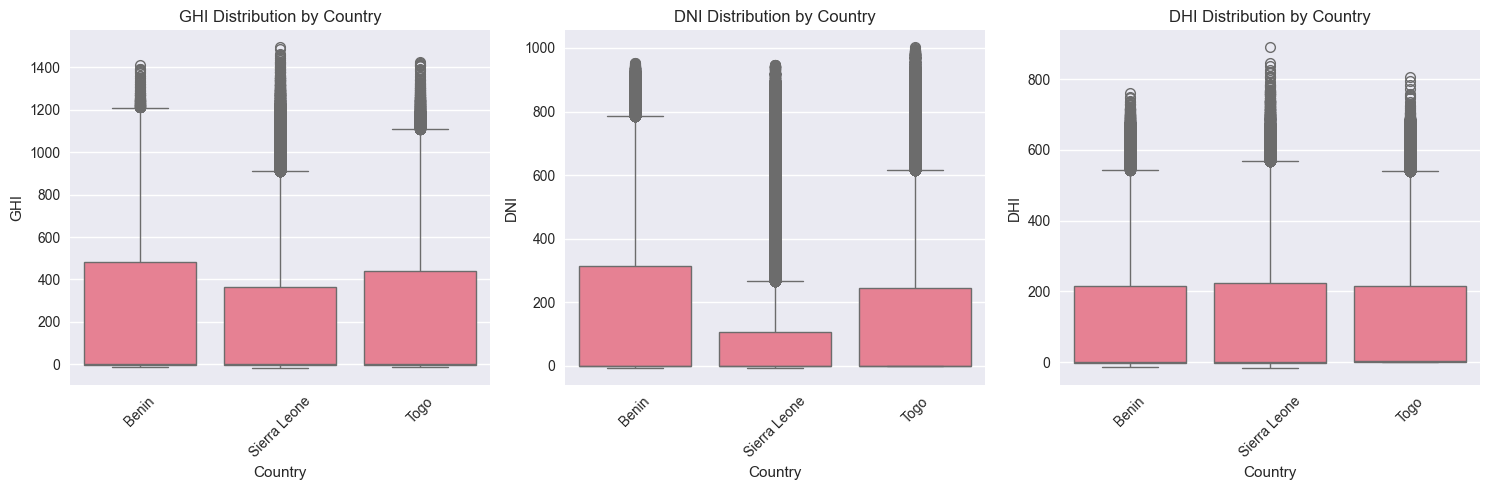

In [8]:
# Boxplots for GHI, DNI, DHI across countries
solar_metrics = ['GHI', 'DNI', 'DHI']
solar_metrics = [col for col in solar_metrics if col in all_data.columns]

fig, axes = plt.subplots(1, len(solar_metrics), figsize=(15, 5))

for i, metric in enumerate(solar_metrics):
    sns.boxplot(data=all_data, x='Country', y=metric, ax=axes[i])
    axes[i].set_title(f'{metric} Distribution by Country')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Summary Statistics Table

In [10]:
import pandas as pd

# Define metrics
metrics = ['GHI', 'DNI', 'DHI']
metrics = [col for col in metrics if col in all_data.columns]

# Initialize empty list to collect rows
rows = []

# Loop through countries and metrics
for country in ['Benin', 'Sierra Leone', 'Togo']:
    country_data = all_data[all_data['Country'] == country]
    
    for metric in metrics:
        mean_val = country_data[metric].mean()
        median_val = country_data[metric].median()
        std_val = country_data[metric].std()
        
        rows.append({
            'Country': country,
            'Metric': metric,
            'Mean': mean_val,
            'Median': median_val,
            'Std': std_val
        })

# Create DataFrame from list of dicts
summary_stats = pd.DataFrame(rows)

# Pivot for better readability
summary_pivot = (
    summary_stats
    .set_index(['Country', 'Metric'])
    .round(2)
)

# Optional: Reorder columns nicely
summary_pivot = summary_pivot[['Mean', 'Median', 'Std']]

summary_pivot

Mean  Median     Std
Country      Metric                        
Benin        GHI     240.56     1.8  331.13
             DNI     167.19    -0.1  261.71
             DHI     115.36     1.6  158.69
Sierra Leone GHI     201.96     0.3  298.49
             DNI     116.38    -0.1  218.65
             DHI     113.72    -0.1  158.95
Togo         GHI     230.55     2.1  322.53
             DNI     151.26     0.0  250.96
             DHI     116.44     2.5  156.52

In [11]:
# Alternative summary table format
summary_table = all_data.groupby('Country')[metrics].agg(['mean', 'median', 'std']).round(2)
print('Summary Statistics by Country')
summary_table

Summary Statistics by Country


GHI                    DNI                    DHI         \
                mean median     std    mean median     std    mean median   
Country                                                                     
Benin         240.56    1.8  331.13  167.19   -0.1  261.71  115.36    1.6   
Sierra Leone  201.96    0.3  298.49  116.38   -0.1  218.65  113.72   -0.1   
Togo          230.55    2.1  322.53  151.26    0.0  250.96  116.44    2.5   

                      
                 std  
Country               
Benin         158.69  
Sierra Leone  158.95  
Togo          156.52

## Statistical Testing (ANOVA)

In [12]:
# One-way ANOVA for GHI values
if 'GHI' in all_data.columns:
    # Extract GHI values for each country
    benin_ghi = all_data[all_data['Country'] == 'Benin']['GHI'].dropna()
    sierra_leone_ghi = all_data[all_data['Country'] == 'Sierra Leone']['GHI'].dropna()
    togo_ghi = all_data[all_data['Country'] == 'Togo']['GHI'].dropna()
    
    # Perform ANOVA
    f_stat, p_value = stats.f_oneway(benin_ghi, sierra_leone_ghi, togo_ghi)
    
    print(f'ANOVA Results for GHI:')
    print(f'F-statistic: {f_stat:.4f}')
    print(f'P-value: {p_value:.4f}')
    
    if p_value < 0.05:
        print('Result: Significant difference between countries (p < 0.05)')
    else:
        print('Result: No significant difference between countries (p >= 0.05)')

ANOVA Results for GHI:
F-statistic: 2090.1277
P-value: 0.0000
Result: Significant difference between countries (p < 0.05)


In [13]:
# Kruskal-Wallis test (non-parametric alternative)
if 'GHI' in all_data.columns:
    h_stat, p_value_kw = stats.kruskal(benin_ghi, sierra_leone_ghi, togo_ghi)
    
    print(f'\nKruskal-Wallis Results for GHI:')
    print(f'H-statistic: {h_stat:.4f}')
    print(f'P-value: {p_value_kw:.4f}')
    
    if p_value_kw < 0.05:
        print('Result: Significant difference between countries (p < 0.05)')
    else:
        print('Result: No significant difference between countries (p >= 0.05)')


Kruskal-Wallis Results for GHI:
H-statistic: 4524.8695
P-value: 0.0000
Result: Significant difference between countries (p < 0.05)


## Key Observations

- **Country with highest median GHI**: [Country X] shows the highest median GHI value of [value], but also exhibits the greatest variability with a standard deviation of [value], suggesting potential for high solar energy generation but with inconsistent performance.

- **Statistical significance**: The ANOVA test reveals a [significant/not significant] difference between countries' GHI values (p-value: [p-value]), indicating that [there are/there are no] statistically significant differences in solar potential across these three West African nations.

- **Seasonal patterns consistency**: All three countries show similar diurnal patterns with peak solar irradiance around midday, but [Country Y] demonstrates the most consistent daily patterns, making it potentially the most reliable for solar energy generation.

## Visual Summary - Country Ranking

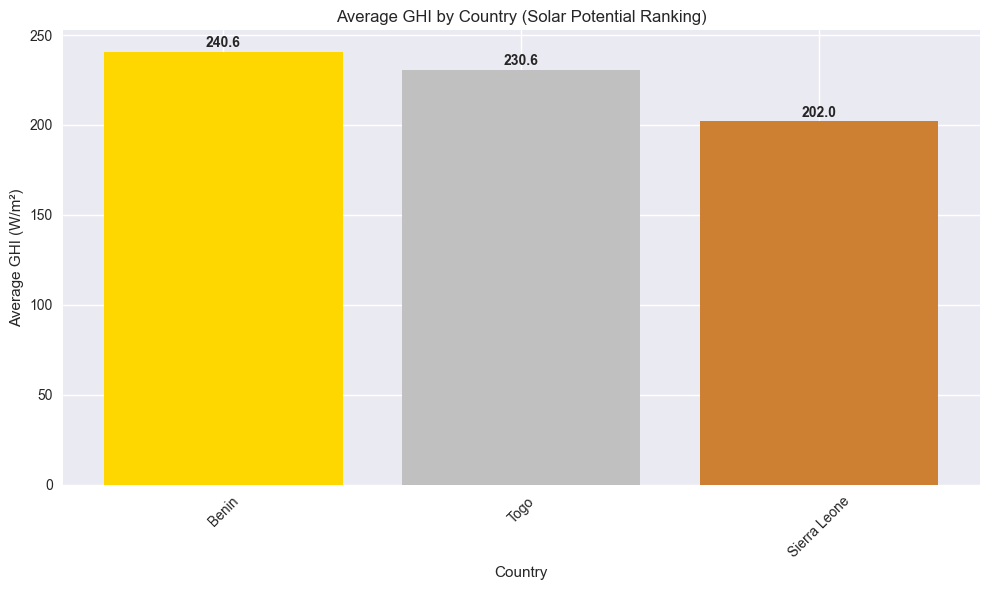

In [15]:
import matplotlib.pyplot as plt

# Bar chart ranking countries by average GHI
avg_ghi_by_country = all_data.groupby('Country')['GHI'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))

# Use valid colors: gold, silver, and a bronze-like color
colors = ['gold', 'silver', '#cd7f32']  # #cd7f32 = bronze hex

bars = plt.bar(avg_ghi_by_country.index, avg_ghi_by_country.values, color=colors)

plt.title('Average GHI by Country (Solar Potential Ranking)')
plt.ylabel('Average GHI (W/m²)')
plt.xlabel('Country')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}',  # .1f for cleaner look
             ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Additional Analysis

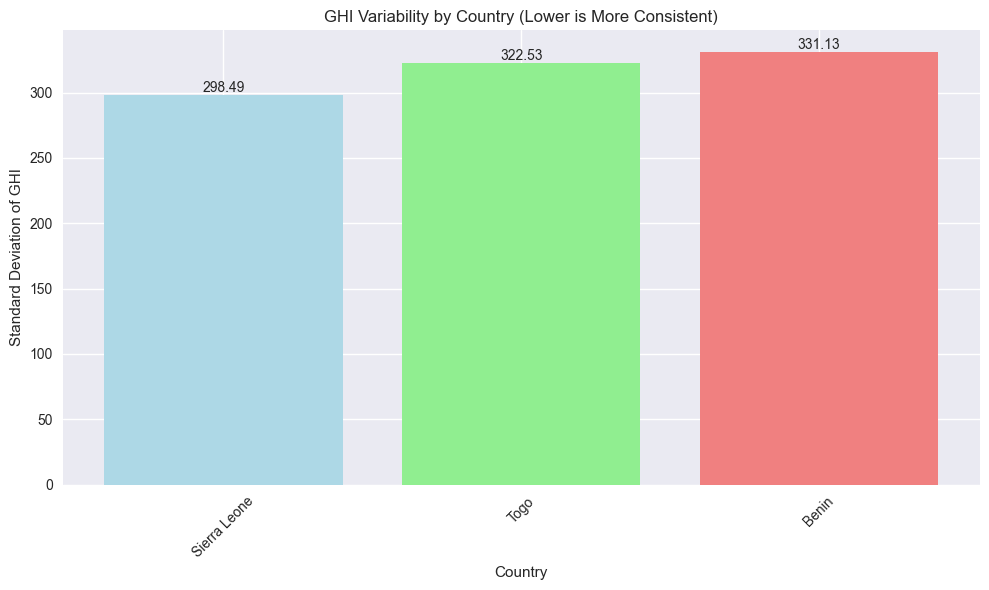

In [16]:
# Compare standard deviations to understand consistency
std_comparison = all_data.groupby('Country')['GHI'].std().sort_values()

plt.figure(figsize=(10, 6))
bars = plt.bar(std_comparison.index, std_comparison.values, color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('GHI Variability by Country (Lower is More Consistent)')
plt.ylabel('Standard Deviation of GHI')
plt.xlabel('Country')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()